## Project 4:  Solving N-Queens Problem using Genetic Algorithms

#### CSC 180  Intelligent Systems

#### Dr. Haiquan Chen, California State University, Sacramento


In [355]:
# Insert your name, your id, course title, assignment id, and due date here as comment 
# Project 4: Due 4/23
#
# Noah Venethongkham, 219660117
# Ashley Thor, 219334909
# Lucas Saechao, 218794239


## Part I: Position-index-based board representation

In [356]:
import random
import math
import numpy as np
# run 'pip install deap'
from deap import algorithms, base, creator, tools
board_size = 5
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [357]:
def create_individual():
    return random.sample(range(board_size * board_size), board_size)

In [358]:
print(create_individual())

[11, 22, 18, 16, 14]


In [359]:
def show_grid(board, board_size):
    dashes = "--------------------------------"
    dashes = dashes[:(board_size * 2)]
    n = [0]*(board_size * board_size)
    for i in board:
        n[i] = 1
    
    count = 0
    for i in range(board_size):
        for j in range(board_size * board_size):
            if j // board_size == i:
                if n[j] == 1:
                    print('X',end="|")
                else:
                    print('-',end="|")
        print()
        print(dashes)
            


In [360]:
toolbox = base.Toolbox()

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [361]:
pop = toolbox.population(n=1000)

print(pop[0])

[12, 2, 4, 20, 5]


In [362]:
show_grid(pop[0], board_size)

-|-|X|-|X|
----------
X|-|-|-|-|
----------
-|-|X|-|-|
----------
-|-|-|-|-|
----------
X|-|-|-|-|
----------


### 10 pts:  Write your code in the cell below to define the "eval_fitness" function, which returns the fitness of any given board.  

- Noticed that in this case, mutation may generate invalid board, e.g., the board with dupliciate positions.  Think about   [5, 32, 8, 8, 41, 3, 55, 49]

- How to exclude those invalid boards from each generation? One way is to add some penalty to the fitness value of invalid boards.  In that case, any invalid board will have a very high fitness value (remember that our goal is to find the board with least fitness value).    To do that, let's write a function ***checkDuplicate()*** to calculate the number of queen pairs in the same position for any given board.   ***Give each duplicate a high penalty (i.e., multiply by 20, 50) and add the penalty to the fitness value.*** 

-  eval_fitness() returns the total number of duplicate position pair (with penalty) plus the total number of distinct pairs of queens that attack each other.  

In [363]:
# Calculate the number of queen pairs in the same position for any given board
def check_duplicate(individual):
    dup = 0
    individual_sorted = sorted(individual)
    duplicates=[]
    for i in individual_sorted:
     if individual_sorted.count(i)>1:
         if i not in duplicates:
             duplicates.append(i)
    dup = len(duplicates)
    
    return dup



## eval_fitness()
For a 1D array representing a board with some N queens, the following is done to check for collisions: first an empty dictionary is created. The dictionary is used to keep track of pair mappings in which an integer key maps to a tuple, representing that collision. Then, we check for a vertical, horizontal, and diagonal collision. A helper method unique_tuples() is given this dictionary, and computes a list of distinct conflicts. The size of this list is the number of distinct conflicts found for this board.

In [364]:
def unique_tuples(d):
    unique = []
    for key in d:
        reverse = ()
        item = d[key]
        for i in reversed(item):
            reverse += (i,)
        if item not in unique and reverse not in unique:
            unique.append(item)
    print(unique)
    return unique

def check_diag_right(i, j, board_size):
    n_upper = board_size + 1
    right_edge = []
    left_edge = []
    for k in range(board_size * board_size):
        if (k + 1) % board_size == 0:
            right_edge.append(k)
        if k % board_size == 0:
            left_edge.append(k)
    
    # directly adjacent
    if i not in right_edge:
        right = i
        if (right + n_upper) == j:
            return True
    
    if i not in left_edge:
        left = i
        if (left - n_upper) == j:
            return True
    
    if j not in right_edge:
        right = j
        if (right + n_upper) == i:
            return True
    
    if j not in left_edge:
        left = j
        if (left - n_upper) == i:
            return True
    # if i > j scan i to the left else scan j to the left
    for l in range(board_size):
        if i > j:
            if i not in left_edge:
                i -= n_upper
                if i == j:
                    return True
            if j not in right_edge:
                j += n_upper
                if j == i:
                    return True
        else:
            if j not in left_edge:
                j -= n_upper
                if j == i:
                    return True
            if i not in right_edge:
                i += n_upper
                if i == j:
                    return True
    return False

def check_diag_left(i, j, board_size):
    n_lower = board_size - 1
    right_edge = []
    left_edge = []
    
    for k in range(board_size * board_size):
        if (k + 1) % board_size == 0:
            right_edge.append(k)
        if k % board_size == 0:
            left_edge.append(k)
    
    # directly adjacent
    if i not in left_edge:
        right = i
        if (right + n_lower) == j:
            return True
    
    if i not in right_edge:
        left = i
        if (left - n_lower) == j:
            return True
    
    if j not in left_edge:
        right = j
        if (right + n_lower) == i:
            return True
    
    if j not in right_edge:
        left = j
        if (left - n_lower) == i:
            return True
    
    # if i > j scan i to the right else scan j to the right
    for l in range(board_size):
        if i > j:
            if i not in right_edge:
                i -= n_lower
                if i == j:
                    return True
            if j not in left_edge:
                j += n_lower
                if j == i:
                    return True
        else:
            if j not in right_edge:
                j -= n_lower
                if j == i:
                    return True
            if i not in left_edge:
                i += n_lower
                if i == j:
                    return True
    return False

def eval_fitness(individual):
    key = 0
    pairs = {}
    n_lower = board_size - 1
    
    for i in individual: 
        for j in individual:
            if i == j:
                continue
            if (i - j) % board_size == 0:
                key += 1
                pairs[key] = (i, j)
            if (math.floor(i / board_size)) == (math.floor(j / board_size)):
                key += 1
                pairs[key] = (i, j)
            if check_diag_right(i, j, board_size): 
                key += 1
                pairs[key] = (i, j)
            if check_diag_left(i, j, board_size):
                key += 1
                pairs[key] = (i, j)
    
    unique = unique_tuples(pairs)
    return ((50*check_duplicate(individual)) + len(unique),)

In [365]:
#list1 = [0, 10, 22, 31, 39, 44, 49, 62]
#list2 = [7, 13, 18, 28, 35, 41, 51, 61]
#list3 = [3, 9, 22, 24, 37, 47, 50, 57]
#list4 = [7, 11, 17, 28, 37, 41, 51, 61]
#print(eval_fitness(list1))
#print(eval_fitness(list2))
#print(eval_fitness(list3))
#print(eval_fitness(list4))
#Should print:
# [(22, 31), (22, 62), (31, 39), (44, 62)]
# (4,)
# [(7, 28), (7, 35), (13, 41), (13, 61), (28, 35), (35, 51)]
# (6,)
# [(3, 24), (9, 57), (22, 50), (22, 57), (50, 57)]
# (5,)
# [(7, 28), (11, 51), (17, 41), (28, 37), (37, 51), (37, 61)]
# (6,)

In [366]:
show_grid(pop[0], board_size)
print(eval_fitness(pop[0]))

-|-|X|-|X|
----------
X|-|-|-|-|
----------
-|-|X|-|-|
----------
-|-|-|-|-|
----------
X|-|-|-|-|
----------
[(12, 2), (12, 4), (12, 20), (2, 4), (4, 20), (20, 5)]
(6,)


In [367]:
print(check_duplicate(pop[0]))

0


### 5 pts:  Writer your code in the cell below to register "evaluate" function to toolbox

In [368]:

toolbox.register("evaluate", eval_fitness)


In [369]:
toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutUniformInt, low = 0, up = (board_size * board_size), indpb=0.1)

toolbox.register("select", tools.selTournament, tournsize=3)

In [370]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

In [371]:
stats.register("avg", np.mean)
stats.register("min", np.min)

### 10 pts:  Writer your code in the cell below to create the first generation, the hall of fame, and launch the genetic algorithm: eaSimple().   How many individuals you want to have for each generation and how many generations you want GA to go thourgh for each run?     Vary those two parameters to see the change.

#### The *simple evolutionary algorithm* takes 5 arguments, a population, a toolbox, a probability of cross-overing two individuals (`cxpb`), a probability of mutating each individual (`mutpb`) and a number of generations to accomplish (`ngen`). 

In [372]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

stats = tools.Statistics(key=lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("min", np.min)

# 0  1  2  3
# 4  5  6  7
# 8  9 10 11
#12 13 14 15

pop = toolbox.population(n=1000)

hof = tools.HallOfFame(maxsize=10)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, 
                                   stats=stats, halloffame=hof, verbose=True)

[(13, 8), (8, 4)]
[(7, 2), (21, 23), (21, 20), (23, 20)]
[(5, 20), (14, 19)]
[(2, 1), (2, 12), (2, 4), (1, 4), (12, 24), (12, 4), (24, 4)]
[(12, 8), (12, 22), (12, 24), (9, 8), (9, 24), (22, 24)]
[(0, 24), (0, 5), (24, 21), (16, 21)]
[(0, 24), (0, 6), (24, 9), (24, 6), (11, 6), (9, 6)]
[(3, 2), (3, 15), (3, 1), (2, 22), (2, 1)]
[(7, 1), (7, 8), (0, 1), (0, 20), (20, 8)]
[(19, 9), (19, 17), (0, 6), (9, 6), (9, 17)]
[(17, 11), (11, 6), (6, 8), (8, 20)]
[(8, 16), (8, 2), (17, 16), (17, 2), (17, 11), (16, 11)]
[(13, 21), (13, 18), (13, 7), (21, 20)]
[(1, 21), (1, 11), (1, 7), (15, 21), (15, 11), (15, 7), (21, 11), (11, 7)]
[(20, 12), (20, 4), (19, 4), (2, 12), (2, 4), (12, 4)]
[(16, 17), (16, 12), (17, 12), (17, 9), (12, 14), (14, 9)]
[(6, 11), (6, 8), (6, 0), (11, 14), (8, 14)]
[(5, 23), (16, 12), (23, 3)]
[(20, 16), (20, 0), (16, 18), (18, 0)]
[(1, 4), (1, 13), (1, 5), (4, 24)]
[(0, 4), (0, 18), (4, 8), (8, 18), (17, 18)]
[(7, 6), (7, 13), (7, 19), (6, 21), (21, 13), (13, 19)]
[(8, 5), (

[(17, 11), (14, 11), (14, 8), (20, 8)]
[(1, 13), (1, 16), (15, 16)]
[(1, 16), (1, 6), (20, 15), (20, 16), (15, 16), (16, 6)]
[(5, 8), (5, 11)]
[(9, 17), (9, 5), (17, 18), (17, 5), (17, 11), (5, 11)]
[(1, 0), (1, 7), (24, 0), (8, 7)]
[(10, 12), (10, 13), (10, 2), (12, 13), (12, 2), (13, 19)]
[(9, 3), (9, 8), (9, 4), (1, 3), (1, 4), (3, 8), (3, 4), (8, 4)]
[(9, 3), (9, 24), (9, 6), (9, 5), (24, 6), (6, 5)]
[(14, 19), (5, 15), (5, 1), (15, 19), (19, 1)]
[(20, 0), (20, 16), (19, 13), (19, 16)]
[(23, 24), (23, 17), (4, 1), (4, 24)]
[(7, 1), (7, 6), (1, 6), (10, 6), (10, 20)]
[(0, 1), (0, 20), (1, 16), (20, 16)]
[(1, 6), (1, 0), (1, 16), (6, 0), (6, 16), (17, 16)]
[(8, 2), (8, 16), (8, 9), (2, 22), (22, 16)]
[(16, 12), (16, 21), (16, 20), (12, 20), (21, 20)]
[(6, 8), (6, 21), (6, 0)]
[(11, 6), (11, 10), (20, 10), (6, 10)]
[(0, 24), (0, 2), (8, 2)]
[(0, 15), (21, 15), (21, 13), (13, 14)]
[(16, 15), (16, 11), (14, 11), (0, 15), (15, 11)]
[(15, 11), (15, 10), (11, 23), (11, 10), (11, 12), (10, 

[(7, 12), (7, 3), (7, 11), (7, 13), (12, 11), (12, 13), (3, 11), (3, 13), (11, 13)]
[(12, 7), (12, 20), (12, 17), (12, 16), (7, 17), (20, 16), (17, 16)]
[(2, 8), (11, 16), (16, 8), (16, 18), (8, 18)]
[(15, 17), (15, 10)]
[(12, 22), (12, 17), (12, 7), (23, 22), (23, 17), (22, 17), (22, 7), (17, 7)]
[(12, 24), (12, 16), (16, 15), (3, 15)]
[(6, 1), (6, 5), (6, 18), (22, 18), (1, 5)]
[(17, 11), (20, 8), (11, 6), (6, 8)]
[(5, 9), (5, 20), (5, 1), (5, 23), (20, 23)]
[(16, 6), (16, 12), (16, 10), (6, 0), (6, 12), (6, 10), (0, 12), (0, 10), (12, 10)]
[(12, 6), (12, 8), (12, 20), (9, 6), (9, 8), (6, 8), (8, 20)]
[(19, 7), (19, 14), (7, 5), (5, 0)]
[(5, 11), (3, 2), (3, 11)]
[(18, 14), (18, 19), (18, 0), (14, 19)]
[(16, 8), (16, 21), (16, 6), (8, 6), (8, 23), (21, 6), (21, 23)]
[(7, 22), (7, 15), (7, 6), (0, 15), (0, 6)]
[(22, 24), (5, 9), (3, 9), (9, 24)]
[(4, 12), (4, 1), (4, 2), (12, 13), (12, 2), (13, 1), (1, 2)]
[(17, 9), (17, 13), (9, 13), (1, 13)]
[(12, 2), (12, 16), (1, 2), (1, 16)]
[(9,

[(14, 18), (14, 2)]
[(23, 18), (23, 22), (23, 17), (18, 22), (18, 17), (22, 17), (22, 2), (17, 2)]
[(7, 12), (7, 11), (7, 22), (12, 14), (12, 11), (12, 22), (14, 11), (14, 22)]
[(6, 16), (20, 16), (20, 22), (16, 22)]
[(12, 14), (9, 3), (9, 14), (23, 3)]
[(13, 14), (13, 3)]
[(6, 18), (6, 24), (6, 12), (18, 19), (18, 24), (18, 12), (19, 24), (24, 12)]
[(23, 17), (9, 17), (9, 4), (17, 2), (4, 2)]
[(10, 2), (19, 17), (19, 24), (17, 2)]
[(9, 24), (9, 17), (9, 7), (24, 23), (23, 17), (17, 7)]
[(4, 19), (4, 1), (19, 1), (11, 1)]
[(21, 22), (21, 20), (21, 11), (22, 20), (22, 7), (7, 11)]
[(1, 4), (1, 5), (1, 13), (12, 4), (12, 13)]
[(18, 13), (21, 13)]
[(16, 21), (16, 1), (21, 24), (21, 1), (2, 1)]
[(14, 8), (14, 18), (8, 18), (0, 15), (0, 18), (15, 18)]
[(7, 19), (7, 8), (19, 16), (16, 8), (16, 20), (8, 20)]
[(0, 4), (0, 10), (10, 11), (11, 21)]
[(5, 6), (5, 10), (5, 1), (14, 10), (6, 10), (6, 1)]
[(22, 20), (22, 7), (22, 16), (22, 21), (20, 16), (20, 21), (16, 21)]
[(5, 6), (5, 23), (5, 10),

[(5, 7), (14, 18)]
[(0, 5), (0, 18), (0, 4)]
[(24, 21), (24, 4), (8, 4), (8, 3), (4, 3)]
[(15, 5), (5, 23), (13, 23)]
[(8, 9), (8, 14), (9, 14)]
[(6, 11), (6, 0), (6, 21), (22, 21), (11, 21)]
[(8, 6), (1, 6)]
[(12, 14), (12, 7), (5, 7)]
[(7, 17), (17, 23), (23, 20), (4, 20)]
[(9, 13), (9, 3), (9, 4), (13, 3), (2, 3), (2, 4), (3, 4)]
[(4, 20), (20, 22), (11, 13)]
[(15, 5), (15, 3), (5, 23), (3, 4), (3, 23)]
[(22, 24), (8, 9), (9, 24)]
[(4, 3), (7, 5), (7, 3)]
[(17, 7), (17, 22), (7, 22)]
[(1, 21), (1, 7), (12, 7), (21, 23)]
[(15, 0), (24, 0), (0, 1)]
[(3, 11), (3, 0)]
[(18, 16), (18, 14), (16, 20), (9, 14)]
[(17, 9), (17, 11), (17, 13), (9, 13), (11, 13)]
[(19, 1), (3, 1), (3, 0), (1, 0), (20, 0)]
[(24, 9), (11, 16)]
[(21, 20), (20, 8), (18, 8), (8, 7)]
[(7, 19), (7, 5), (19, 24), (24, 21)]
[(13, 3), (13, 23), (13, 12), (3, 23), (12, 16)]
[(20, 8), (20, 4), (20, 16), (8, 4), (8, 3), (8, 16), (4, 3), (4, 16)]
[(17, 5), (17, 9), (5, 9), (5, 20), (14, 9)]
[(24, 6), (24, 0), (6, 1), (6, 0),

[(11, 6), (11, 16), (11, 3), (6, 16), (6, 2), (3, 2)]
[(23, 21), (1, 21), (1, 7)]
[(3, 2), (3, 11)]
[(23, 24), (23, 17), (4, 1), (4, 24)]
[(23, 19), (23, 18), (19, 18), (19, 15), (18, 15)]
[(16, 21), (16, 12), (16, 17), (21, 17), (2, 12), (2, 17), (12, 17)]
[(14, 9), (14, 24), (9, 24)]
[(24, 4), (8, 4), (8, 5)]
[(11, 16), (11, 17), (16, 17), (16, 22), (2, 17), (2, 22), (17, 22)]
[(17, 16), (17, 18), (17, 22), (0, 18), (16, 18), (16, 22), (18, 22)]
[(9, 14), (9, 24), (1, 16), (14, 24)]
[(7, 9), (18, 0)]
[(22, 16), (22, 20), (16, 11), (16, 4), (16, 20), (4, 20)]
[(20, 16), (20, 23), (20, 5), (1, 16), (1, 5), (23, 5)]
[(15, 10), (15, 18), (15, 21), (1, 21)]
[(19, 9), (19, 17), (19, 4), (9, 17), (9, 4), (17, 2), (4, 2)]
[(23, 21), (23, 3), (23, 11), (21, 11), (3, 11), (14, 11)]
[(20, 0), (20, 22), (3, 0)]
[(18, 13), (18, 6), (18, 22), (13, 9), (9, 6)]
[(20, 22), (20, 15), (20, 24), (3, 15), (22, 24)]
[(10, 11), (10, 14), (10, 0), (11, 14), (11, 7)]
[(5, 15), (5, 1), (3, 15), (3, 1)]
[(7, 3

[(13, 7), (13, 3), (13, 14), (7, 3), (7, 15), (3, 15)]
[(17, 5), (10, 5), (5, 1)]
[(14, 18), (16, 1), (16, 18)]
[(5, 23), (5, 6), (23, 3)]
[(15, 5), (5, 9), (14, 9)]
[(4, 12), (4, 1), (12, 10), (12, 17)]
[(8, 2), (8, 9), (8, 18), (8, 20)]
[(20, 10), (20, 5), (10, 5), (10, 6), (5, 6)]
[(19, 9), (0, 10)]
[(8, 20), (8, 5), (8, 2), (20, 21), (20, 5)]
[(2, 8), (2, 0), (2, 17), (8, 16), (17, 16)]
[(7, 13), (7, 12), (23, 13), (23, 20), (13, 12), (20, 12)]
[(18, 23), (18, 0), (23, 11)]
[(13, 14), (13, 21), (13, 19), (14, 19)]
[(22, 23), (5, 23), (5, 15), (23, 3), (3, 15)]
[(7, 19), (10, 0), (10, 14), (19, 14)]
[(21, 9), (21, 20), (8, 9), (8, 20), (0, 20)]
[(16, 20), (13, 14), (13, 3)]
[(15, 17), (15, 10)]
[(12, 24), (3, 15), (15, 5)]
[(12, 24), (12, 17), (12, 20), (24, 20)]
[(19, 24), (24, 22), (10, 22)]
[(18, 14), (18, 8), (18, 19), (18, 0), (14, 8), (14, 19)]
[(22, 21), (1, 21), (1, 0), (21, 9)]
[(24, 21), (5, 1), (5, 8), (1, 21)]
[(24, 4), (1, 4), (1, 3), (8, 4), (8, 3), (4, 3)]
[(24, 18), 

[(10, 5), (10, 22)]
[(10, 5), (10, 11), (5, 11), (5, 23), (11, 23), (23, 24)]
[(24, 9), (24, 18), (24, 20)]
[(16, 15), (16, 20), (3, 15), (24, 20), (15, 20)]
[(5, 1), (2, 3), (2, 1), (13, 3), (13, 1), (3, 1)]
[(7, 15), (7, 12), (15, 21), (14, 12)]
[(17, 21), (17, 15), (17, 22), (21, 15), (21, 22)]
[(12, 4), (12, 10), (12, 7), (12, 18)]
[(13, 9), (13, 21), (13, 23), (9, 21), (21, 23), (21, 15)]
[(5, 0), (13, 14), (14, 4), (0, 4)]
[(13, 1), (13, 3), (16, 1), (1, 3)]
[(2, 22), (2, 12), (22, 12), (5, 9)]
[(12, 8), (12, 20), (12, 11), (15, 20), (15, 11), (8, 20)]
[(0, 5), (0, 4), (7, 5), (4, 16)]
[(20, 5), (20, 24), (20, 16), (20, 8), (5, 8), (16, 8)]
[(5, 6)]
[(15, 5), (5, 23), (13, 23)]
[(1, 16), (1, 0)]
[(2, 17), (2, 8), (16, 17), (16, 8)]
[(24, 0), (24, 23), (13, 23), (5, 0), (5, 23)]
[(5, 11), (5, 7), (11, 7), (2, 7)]
[(13, 18), (24, 18), (24, 20)]
[(10, 16), (10, 2), (16, 8), (8, 2)]
[(17, 11), (11, 6), (6, 24), (24, 20)]
[(5, 11), (11, 21)]
[(8, 13), (21, 13), (21, 11), (21, 15), (13

[(14, 12), (16, 12), (23, 3)]
[(5, 1), (16, 1), (3, 1)]
[(18, 17), (5, 17), (21, 17)]
[(22, 16), (22, 2)]
[(16, 21), (16, 15), (0, 15), (21, 13), (21, 15)]
[(22, 16), (22, 12), (16, 12), (16, 11), (16, 15), (12, 11), (11, 15)]
[(8, 4), (8, 20), (21, 11), (21, 20), (4, 20)]
[(18, 16), (18, 3), (16, 20), (3, 7)]
[(24, 14), (14, 8)]
[(7, 8), (7, 19)]
[(21, 24), (21, 16), (10, 16), (16, 8)]
[(2, 7), (2, 0), (15, 7), (15, 0), (9, 7)]
[(14, 13), (13, 23), (5, 0), (5, 23)]
[(8, 3), (8, 7), (8, 4), (3, 0), (3, 7), (3, 4), (0, 4)]
[(4, 20), (4, 19), (18, 19), (18, 13), (19, 13)]
[(1, 11), (11, 10), (11, 17), (10, 20)]
[(14, 22), (14, 19)]
[(13, 7), (13, 8), (13, 21), (7, 8), (7, 5), (8, 5)]
[]
[(21, 24), (21, 15), (24, 19), (7, 15), (7, 19), (15, 19)]
[(23, 17), (10, 2), (17, 7), (17, 2), (7, 2)]
[(9, 4), (23, 22), (16, 4), (16, 22)]
[(4, 3), (13, 3), (13, 7), (5, 7), (3, 7)]
[(21, 23), (8, 18), (8, 23), (18, 0), (18, 23)]
[(9, 19), (19, 1), (11, 1)]
[(16, 22), (16, 21), (16, 19), (22, 21), (21

[(19, 1), (1, 11)]
[(0, 24), (0, 2), (8, 2)]
[(24, 4), (24, 22), (24, 14), (4, 14), (22, 14)]
[(20, 15), (18, 15)]
[(15, 16), (15, 3), (9, 3), (22, 16)]
[(1, 11)]
[(21, 17), (17, 19)]
[(0, 6), (6, 8), (14, 8), (8, 23)]
[(5, 1), (21, 1), (19, 1)]
[(14, 12), (12, 20), (20, 5)]
[(7, 6), (24, 6), (16, 6), (16, 10), (6, 10)]
[(13, 21), (16, 21)]
[(4, 14), (17, 22), (14, 22)]
[(9, 7), (9, 5), (9, 24), (7, 5)]
[(10, 0)]
[(14, 18), (14, 9), (9, 5), (5, 1)]
[(2, 1), (1, 21), (20, 21)]
[(15, 5), (5, 23)]
[(21, 13), (21, 23), (5, 23), (13, 23), (13, 14)]
[(22, 16), (16, 11), (16, 6), (11, 6), (6, 0)]
[(22, 21), (22, 7), (22, 18)]
[(13, 11), (13, 18), (11, 6), (6, 18)]
[(17, 11), (17, 2), (2, 8), (8, 20)]
[(24, 0), (24, 20), (25, 0), (25, 20), (0, 20)]
[(23, 3), (7, 3), (7, 2), (3, 2), (2, 10)]
[(22, 21), (3, 1), (5, 1), (21, 1)]
[(0, 5), (0, 6), (14, 19), (5, 6)]
[(22, 23), (5, 1), (5, 23), (5, 0), (1, 0)]
[(24, 21), (16, 11), (16, 21), (16, 8), (11, 21)]
[(13, 23), (13, 9), (4, 2), (4, 9)]
[(5, 

[(1, 6), (24, 6), (24, 20)]
[(13, 18), (13, 9), (13, 1), (18, 15)]
[(1, 2), (18, 24), (24, 20)]
[(22, 21), (22, 16), (21, 11), (21, 13), (21, 16), (11, 13), (11, 16)]
[(17, 15), (0, 15)]
[(17, 19), (19, 14)]
[(4, 0), (0, 5), (0, 6), (5, 6)]
[(17, 23), (17, 19), (17, 22), (23, 19), (23, 22), (10, 22)]
[(0, 4), (11, 23)]
[(4, 20), (20, 5), (5, 7)]
[(24, 21), (24, 9), (21, 11), (21, 9)]
[(11, 13), (11, 14), (11, 16), (13, 14), (14, 2)]
[(5, 15), (5, 1), (15, 3), (1, 3)]
[(21, 24), (24, 19)]
[(16, 20), (2, 3), (9, 3)]
[(1, 2), (1, 21), (21, 20)]
[(22, 24), (4, 24), (4, 19), (24, 19)]
[(17, 7), (17, 23), (7, 6)]
[(20, 8), (20, 16), (8, 16), (8, 9), (8, 6), (16, 6), (9, 6)]
[(13, 3), (13, 23), (13, 10), (3, 23), (6, 10)]
[(16, 20), (16, 17), (16, 10), (20, 10), (13, 17), (13, 10)]
[(8, 4), (8, 14), (8, 3), (4, 14), (4, 3)]
[(20, 0), (1, 0)]
[(21, 16), (21, 23), (8, 16), (8, 23), (19, 16), (19, 23)]
[(12, 8), (8, 5), (19, 15), (15, 5)]
[(13, 3), (13, 21), (24, 21)]
[(24, 23), (15, 17), (17, 2

[(19, 15), (19, 13), (22, 20), (15, 20)]
[(20, 21), (20, 15), (21, 1), (21, 15)]
[(3, 18), (3, 9), (3, 1), (18, 14), (9, 14)]
[(2, 6), (2, 4)]
[(8, 5)]
[(21, 24), (24, 19)]
[(21, 24), (24, 19)]
[(16, 21), (0, 5), (21, 13)]
[(6, 16), (6, 7), (16, 4)]
[(5, 1), (5, 8), (1, 16), (1, 21), (8, 16), (16, 21)]
[(24, 14), (24, 19), (13, 14), (13, 19), (14, 19), (19, 15)]
[(10, 6), (21, 6)]
[(7, 1), (7, 3), (10, 20), (1, 3)]
[(2, 7), (2, 10), (5, 7), (5, 10), (5, 20), (10, 20)]
[(18, 14), (18, 16), (14, 9), (16, 20)]
[(24, 6), (24, 23), (7, 6), (7, 8), (6, 8), (23, 8)]
[(5, 8), (18, 19), (18, 8), (18, 12), (8, 12)]
[(1, 21), (1, 6), (1, 4), (21, 6), (21, 17)]
[(4, 24), (4, 8), (24, 18), (8, 18), (8, 7)]
[(15, 21), (15, 5), (15, 18), (21, 1), (5, 1)]
[(8, 6), (8, 13), (6, 0), (0, 15)]
[(22, 18), (0, 5), (0, 18), (19, 18)]
[(22, 14), (22, 16), (4, 14), (4, 16), (6, 16)]
[(6, 0), (0, 4), (19, 4), (19, 14), (4, 14)]
[(23, 17), (6, 16), (6, 7), (16, 17), (17, 7)]
[(0, 15), (0, 2), (13, 9)]
[(4, 8), (

[(4, 2), (4, 3), (4, 20), (2, 3), (13, 3)]
[(16, 22), (13, 3)]
[(13, 11), (13, 9), (11, 16), (11, 5), (9, 5)]
[(2, 22), (19, 13)]
[(20, 24), (20, 16), (7, 17), (17, 16)]
[(2, 7), (2, 0), (7, 13), (0, 20)]
[(19, 1), (19, 7), (1, 7), (1, 11), (7, 11)]
[(14, 22), (14, 8), (14, 24), (22, 24)]
[(19, 13), (13, 3)]
[(1, 0), (8, 9)]
[(16, 17), (16, 20), (2, 17), (17, 23), (23, 20)]
[(7, 2)]
[(5, 9), (5, 20), (24, 9), (24, 20), (16, 20)]
[(8, 7), (8, 3), (7, 3)]
[(21, 23), (21, 15), (10, 15), (23, 3), (3, 15)]
[(21, 9), (21, 22), (9, 8), (9, 14), (22, 14), (8, 14)]
[(8, 5), (5, 0), (5, 11)]
[(7, 19), (7, 3), (7, 13), (19, 13), (3, 13), (3, 0)]
[(16, 20), (16, 1), (13, 1), (13, 3), (1, 3)]
[(9, 14)]
[(23, 18), (18, 16)]
[(20, 16), (1, 2), (1, 16), (1, 11), (16, 11)]
[(12, 7), (12, 18), (19, 7), (19, 18)]
[(4, 8), (4, 0), (4, 3), (8, 3), (0, 3)]
[(10, 11), (17, 11)]
[(22, 20)]
[(8, 9)]
[(24, 20), (24, 0), (15, 17), (15, 20), (15, 0), (20, 0)]
[(1, 7), (9, 7), (10, 20)]
[(23, 21), (1, 21), (1, 16)

[(2, 17), (17, 5), (17, 15), (5, 15)]
[(21, 17), (21, 9), (17, 9), (17, 18)]
[(15, 5), (15, 3), (15, 19), (2, 3)]
[(0, 2), (0, 1), (11, 1), (11, 23), (2, 1)]
[(5, 9), (9, 19), (9, 21), (16, 19), (16, 21)]
[(21, 17), (10, 14)]
[]
[(5, 7)]
[(4, 12), (12, 18), (12, 7), (5, 7)]
[(19, 1), (1, 21)]
[(21, 16), (21, 9), (21, 13), (5, 9), (9, 13)]
[(2, 8), (2, 0), (2, 1), (19, 1), (0, 1)]
[(5, 7)]
[(4, 8), (4, 19), (4, 0), (8, 23), (19, 23)]
[(5, 11)]
[(13, 21), (21, 16)]
[(22, 20), (15, 5), (15, 20), (5, 8), (5, 20), (8, 20)]
[(12, 22), (12, 13), (12, 4)]
[(2, 3), (23, 3), (9, 3)]
[(5, 15)]
[(0, 3), (0, 1), (3, 1), (3, 23), (16, 1)]
[(13, 9), (13, 23), (9, 6), (16, 6)]
[(9, 8), (23, 8)]
[(1, 2), (24, 18), (24, 20)]
[(12, 8), (19, 1), (8, 5), (1, 5)]
[(8, 3), (0, 3)]
[(2, 10), (23, 24), (16, 10)]
[(11, 15), (24, 9)]
[(5, 11), (11, 14), (11, 3), (2, 14), (2, 3)]
[(16, 20), (16, 19), (16, 21), (20, 21), (13, 19), (13, 21)]
[(17, 5), (17, 7), (5, 6), (5, 7), (6, 7)]
[(4, 2), (21, 22), (2, 22), (18

[(2, 10), (2, 17), (2, 4), (10, 13), (17, 13)]
[(4, 3), (4, 19)]
[(5, 8), (13, 8)]
[(16, 15), (9, 13)]
[(2, 14), (23, 18), (23, 5), (18, 14)]
[(21, 24), (21, 6), (10, 6), (24, 19), (24, 6)]
[(3, 2), (17, 19), (17, 2)]
[(17, 23), (10, 14), (8, 14), (8, 23)]
[(24, 0), (0, 1)]
[(17, 16), (17, 23), (1, 16), (16, 10)]
[(24, 14), (2, 14), (13, 14)]
[(20, 16), (1, 16), (1, 3)]
[(17, 16), (17, 23), (8, 16), (8, 23), (16, 1)]
[(0, 15), (9, 19), (9, 14), (19, 15), (19, 14)]
[(9, 14), (11, 14), (11, 23)]
[]
[(23, 13), (1, 2), (1, 13)]
[(21, 15), (10, 15), (10, 2), (8, 2)]
[(23, 24), (23, 3), (1, 3), (24, 12)]
[(13, 14), (13, 3)]
[(5, 8), (13, 19), (13, 8)]
[(14, 24), (14, 9), (14, 2), (24, 9), (24, 6), (9, 6), (6, 2)]
[(13, 8), (13, 3), (22, 2), (8, 3), (8, 2), (3, 2)]
[(21, 16), (10, 5), (10, 16), (16, 19)]
[(4, 0), (0, 18)]
[(5, 8), (8, 12)]
[(8, 18), (18, 19)]
[(2, 10), (2, 3), (2, 0), (10, 0), (24, 0), (3, 0)]
[(10, 12)]
[(2, 1), (1, 16)]
[(5, 17), (17, 16), (17, 2)]
[(13, 14), (13, 3)]
[(20,

[(17, 18), (17, 19), (14, 18), (14, 19), (3, 18), (18, 19)]
[(5, 1), (14, 2), (1, 16), (1, 2)]
[(20, 21), (11, 21)]
[(21, 23), (19, 23), (8, 23)]
[(3, 9), (3, 7), (9, 7), (9, 14)]
[(21, 23), (5, 23), (19, 23)]
[(4, 3), (3, 18), (3, 7), (5, 7)]
[(22, 21), (22, 18), (22, 7), (5, 7)]
[(5, 7)]
[(5, 7)]
[(17, 21), (17, 19), (21, 1), (19, 1)]
[(5, 8), (5, 0), (24, 0), (24, 12), (8, 12), (0, 12)]
[(21, 17), (3, 8), (3, 18), (17, 18), (8, 18)]
[(2, 0), (2, 6), (11, 6), (0, 6)]
[(10, 16), (17, 16)]
[]
[(2, 8), (2, 14), (8, 14), (8, 5)]
[(19, 9), (19, 15), (9, 5), (15, 5)]
[(20, 21), (21, 11)]
[(5, 8), (13, 19), (13, 8)]
[(23, 13)]
[]
[(2, 3), (2, 1), (3, 9), (3, 1)]
[(24, 20), (24, 14), (15, 17), (15, 20)]
[(11, 7), (7, 8), (7, 19)]
[(21, 24), (21, 9), (21, 15), (24, 9)]
[(4, 16), (21, 11), (21, 13), (21, 16), (11, 13), (11, 16)]
[(22, 24), (22, 18), (22, 7), (0, 24), (0, 18), (24, 18)]
[(19, 9), (20, 5), (9, 5)]
[(2, 4), (23, 21), (21, 15)]
[(10, 14), (14, 19)]
[(5, 8), (13, 8), (13, 3), (8, 1

[(10, 2), (18, 19)]
[(5, 11), (11, 3), (11, 21), (24, 21)]
[(4, 19)]
[(16, 21), (16, 10), (16, 1), (21, 1), (2, 10), (2, 1)]
[(21, 16), (0, 3)]
[(5, 10), (13, 14), (13, 10), (14, 10)]
[(11, 15), (11, 13), (9, 13)]
[(21, 17), (21, 15), (17, 15), (17, 7), (15, 7)]
[(22, 18), (9, 5), (5, 1)]
[(17, 23), (23, 24)]
[(4, 9), (4, 20), (10, 15), (10, 20), (15, 20)]
[(8, 3), (8, 5), (24, 21)]
[(13, 21), (13, 7), (13, 1), (21, 1), (4, 1), (7, 1)]
[(3, 13)]
[(24, 22), (22, 16), (22, 2)]
[(23, 13), (9, 13)]
[(17, 23), (10, 14)]
[(9, 24), (9, 17), (24, 20), (10, 20)]
[(20, 16), (20, 23), (14, 2)]
[]
[(17, 23), (17, 16)]
[]
[(22, 18), (22, 7), (5, 7)]
[(14, 18), (16, 18), (0, 18)]
[(5, 1), (13, 19), (13, 1), (19, 1)]
[(9, 3), (10, 16), (23, 3)]
[(1, 7), (15, 17), (15, 7), (17, 7)]
[(4, 1), (4, 20), (10, 20), (23, 20)]
[(10, 0)]
[(5, 7)]
[(2, 12)]
[(2, 17), (17, 9), (17, 15), (17, 13), (9, 13)]
[(5, 15), (14, 4)]
[(22, 24), (22, 17), (22, 16), (22, 2), (17, 16), (17, 2)]
[(8, 14)]
[(13, 19), (13, 3), 

[(5, 11), (11, 3), (2, 3)]
[(0, 10), (10, 22)]
[(3, 13), (3, 9), (13, 9), (13, 19), (9, 19)]
[(4, 8), (21, 22), (5, 8)]
[(5, 15), (5, 7), (13, 18), (13, 7), (15, 18), (15, 7)]
[(23, 18)]
[(5, 20), (5, 0), (5, 1), (5, 7), (20, 0), (0, 1), (1, 7)]
[]
[(8, 18), (8, 7)]
[(2, 7), (23, 5), (23, 18), (5, 7)]
[(4, 9), (13, 9), (9, 5)]
[(22, 23), (22, 14), (9, 14), (9, 4), (14, 4)]
[(15, 5), (15, 20), (5, 20)]
[(4, 9), (4, 16), (4, 14), (9, 14)]
[(0, 5), (0, 18), (5, 7)]
[(20, 10), (3, 18), (3, 1)]
[(0, 10), (10, 14), (17, 23)]
[(4, 9), (9, 7)]
[(2, 4)]
[(10, 5)]
[(5, 10), (5, 7)]
[(4, 19), (4, 8), (13, 19), (13, 8)]
[(0, 10), (10, 14)]
[(11, 15), (19, 15), (0, 15)]
[(19, 14), (8, 14)]
[(19, 23), (8, 23), (21, 23)]
[(24, 9), (9, 5)]
[(22, 17), (11, 17), (11, 6)]
[(2, 0)]
[(23, 13), (9, 13)]
[(2, 8), (2, 3), (23, 8), (23, 3), (23, 19), (8, 3)]
[(21, 9), (21, 15), (21, 13), (10, 15), (10, 13), (9, 13)]
[(16, 15), (2, 3), (9, 3), (15, 3)]
[(21, 13), (19, 13)]
[(4, 14), (13, 14), (13, 18), (13, 7),

[(2, 0), (2, 14), (0, 25)]
[]
[(9, 8), (10, 22)]
[(10, 16), (16, 1)]
[(5, 17), (17, 19)]
[(20, 16), (13, 14), (16, 6)]
[(10, 14), (14, 19)]
[(13, 11), (13, 18), (11, 15), (15, 18)]
[(10, 2), (2, 1)]
[(7, 8), (7, 1), (23, 8)]
[(18, 16), (16, 20)]
[(8, 14), (19, 14)]
[(17, 19)]
[]
[(4, 3), (3, 18), (3, 7)]
[(10, 2), (2, 7)]
[(24, 19), (19, 17), (19, 1)]
[(2, 8), (8, 5)]
[(0, 5), (5, 23)]
[(21, 16), (21, 9), (21, 20), (16, 20)]
[(4, 8), (4, 12), (10, 5), (10, 12), (5, 8), (8, 12)]
[(5, 7), (19, 18), (19, 7)]
[(9, 5), (9, 3), (10, 5), (5, 1), (3, 1)]
[(4, 8), (13, 8)]
[]
[(5, 17), (21, 17), (17, 2), (2, 3)]
[(4, 0), (4, 16), (21, 16), (5, 0)]
[(7, 9), (23, 18)]
[(2, 3), (2, 17), (2, 6), (17, 19)]
[(20, 22), (20, 5), (5, 9), (9, 13)]
[(2, 22), (21, 22)]
[(8, 4), (8, 18), (19, 4), (19, 18)]
[(21, 24), (24, 18), (24, 19), (18, 19)]
[(4, 3), (5, 7), (3, 7)]
[(21, 22), (5, 0)]
[(7, 9), (7, 3), (9, 3), (23, 3)]
[(4, 3), (4, 14), (4, 19), (14, 19)]
[(2, 8), (2, 10), (19, 13), (8, 13), (10, 13)]
[

[(21, 9), (5, 9)]
[(2, 14), (23, 13), (9, 14), (9, 13), (14, 13)]
[(0, 18), (16, 18), (18, 23)]
[(13, 11), (13, 8), (13, 1), (11, 1), (2, 8), (2, 1)]
[(23, 18)]
[(23, 13), (9, 13)]
[(10, 5), (3, 4)]
[(10, 5)]
[(10, 14), (7, 3), (7, 19), (14, 19)]
[(0, 10), (10, 14)]
[(1, 3), (1, 5), (3, 8), (5, 8)]
[(14, 10), (14, 19), (16, 10), (16, 21), (16, 19)]
[(4, 19), (23, 19), (23, 22), (10, 22)]
[(16, 10), (16, 17), (17, 7), (3, 7)]
[(21, 9), (5, 9)]
[(4, 9), (4, 12), (13, 9), (13, 18), (13, 12), (18, 12)]
[(21, 16)]
[(21, 23), (23, 5), (23, 3), (23, 19)]
[(2, 10), (2, 4), (10, 15), (9, 4)]
[(5, 10), (5, 23), (23, 3), (3, 4)]
[(4, 19), (19, 18), (19, 7)]
[(18, 3)]
[(4, 19), (4, 8), (4, 0), (19, 7), (8, 7)]
[]
[(5, 9), (13, 14), (13, 9), (13, 3), (14, 9), (9, 3)]
[(11, 10), (11, 1), (2, 10), (2, 1)]
[(0, 20), (19, 9), (8, 9), (8, 20)]
[(21, 24), (21, 13), (10, 13), (24, 19), (13, 19)]
[(22, 24), (4, 24), (4, 3)]
[(5, 15), (5, 17), (5, 9), (15, 17), (15, 3), (17, 9), (9, 3)]
[(24, 0), (13, 1), (

[(13, 11), (13, 8), (13, 12), (13, 19), (11, 12), (8, 12)]
[(4, 8), (4, 0), (4, 14), (8, 14)]
[(19, 18), (19, 7)]
[(21, 22), (5, 0)]
[(21, 22)]
[(21, 15), (21, 13)]
[(4, 9), (23, 5), (5, 15), (5, 9)]
[(4, 3), (10, 5), (5, 7), (3, 7)]
[(2, 7), (21, 24), (24, 18)]
[(21, 11), (19, 14), (11, 14), (2, 14)]
[(4, 1), (13, 23), (13, 1), (23, 22)]
[(4, 24), (10, 5), (5, 7)]
[(8, 18), (8, 7)]
[(21, 23), (23, 5), (23, 3), (23, 19)]
[(5, 0), (5, 7), (0, 18)]
[(2, 10), (10, 16), (10, 13), (9, 13)]
[(23, 13), (9, 13)]
[(16, 21), (16, 18), (16, 12), (18, 12)]
[(24, 21), (24, 18), (5, 7)]
[(5, 7)]
[(1, 0), (15, 0)]
[(9, 21), (9, 19), (21, 20)]
[(5, 11), (11, 3), (2, 3), (18, 3)]
[(8, 13), (21, 15), (21, 13), (21, 11), (15, 11), (13, 11)]
[(20, 4), (20, 10), (9, 4), (9, 7)]
[(10, 14), (14, 19)]
[]
[(11, 7), (2, 7)]
[(4, 3), (4, 19), (17, 19)]
[(21, 22), (22, 18), (22, 7), (8, 18), (8, 7)]
[(10, 5), (10, 0), (10, 14), (5, 0)]
[(21, 23), (21, 13), (23, 18), (23, 13), (18, 13)]
[(2, 10), (2, 7)]
[]
[(5, 7

[(21, 1), (5, 1), (2, 14), (2, 1)]
[(0, 5), (9, 8), (9, 5), (16, 8), (8, 5)]
[(23, 5), (23, 20), (5, 15), (5, 20), (15, 20)]
[(4, 9), (21, 9), (9, 7)]
[(21, 25), (25, 5), (25, 19)]
[(19, 9), (9, 3), (3, 2)]
[(5, 7)]
[(5, 10)]
[(4, 9), (23, 5), (5, 15), (5, 9)]
[(23, 18)]
[(21, 15), (5, 15)]
[(5, 7)]
[(10, 5)]
[(20, 8), (3, 8), (8, 6)]
[(21, 13), (5, 7), (13, 7)]
[(17, 21), (17, 18), (17, 19), (21, 20), (18, 19)]
[(9, 3), (9, 14), (10, 14), (3, 1)]
[(21, 11), (11, 5), (11, 3)]
[(10, 0)]
[]
[(5, 7)]
[(5, 7)]
[(4, 2), (10, 2), (2, 7)]
[(4, 3), (5, 7), (3, 7)]
[(4, 19), (18, 19)]
[(4, 3), (4, 19)]
[(5, 7)]
[(14, 13), (21, 20), (21, 13), (3, 13)]
[]
[(5, 7)]
[(5, 7)]
[(11, 21), (11, 10), (11, 7)]
[(21, 15), (21, 9), (10, 15), (10, 2)]
[(4, 3), (4, 19), (23, 17), (23, 3), (23, 19), (17, 19)]
[(21, 9), (21, 13), (9, 13), (18, 13)]
[(2, 22), (5, 15)]
[(10, 22)]
[(0, 5), (0, 3)]
[(5, 7)]
[(2, 10), (2, 7)]
[(5, 7), (2, 7)]
[(5, 7)]
[(24, 21), (24, 19), (24, 22), (21, 22), (10, 22)]
[(4, 2), (4, 

[(5, 7)]
[(5, 7)]
[(20, 5), (3, 18), (5, 6), (18, 6)]
[(14, 19), (21, 20)]
[(5, 10)]
[(4, 1), (21, 1), (5, 1), (5, 7), (1, 7)]
[]
[(25, 21), (25, 5), (25, 19), (25, 7), (5, 7), (19, 7)]
[(3, 18), (14, 18), (18, 6)]
[(3, 0), (3, 18), (3, 7), (0, 5), (0, 18), (5, 7)]
[(10, 5), (5, 7)]
[(2, 10), (2, 7)]
[(4, 19), (5, 7), (19, 7)]
[(3, 18), (21, 22), (18, 22)]
[(4, 9), (21, 9), (21, 13), (5, 9), (9, 13)]
[(2, 7), (5, 7), (16, 18)]
[(4, 3), (4, 19)]
[]
[]
[(8, 5), (0, 5)]
[(5, 8), (18, 8)]
[(5, 10)]
[(10, 5), (5, 7)]
[(3, 4), (3, 18), (14, 4), (14, 18)]
[(20, 5), (5, 6), (2, 6)]
[(10, 5), (5, 7)]
[(5, 10)]
[(20, 5), (3, 18), (5, 6), (18, 6)]
[(21, 22), (21, 17), (22, 17), (17, 19)]
[(20, 21), (21, 17), (21, 6), (17, 19)]
[(4, 3), (3, 18), (3, 7), (5, 7)]
[]
[(5, 7)]
[(10, 5)]
[(3, 1), (1, 6)]
[(5, 10), (5, 7)]
[(4, 8), (23, 8)]
[(4, 2), (10, 15), (10, 2), (10, 6), (2, 6)]
[(5, 17), (5, 6), (17, 19)]
[(23, 20), (15, 20)]
[(3, 2), (3, 4), (3, 18), (2, 4)]
[(20, 5), (20, 8), (5, 8), (5, 6), (8

[(4, 19), (4, 3)]
[(4, 19), (5, 7), (19, 7)]
[(3, 18), (17, 18), (18, 6)]
[(21, 17), (5, 17), (5, 7), (17, 7)]
[(19, 14), (8, 14)]
[(21, 22), (22, 7), (5, 7), (3, 7)]
[(4, 19), (18, 19)]
[(24, 19), (19, 1)]
[(21, 11), (21, 16), (11, 16), (16, 19)]
[(2, 3)]
[(4, 1), (21, 1), (5, 1), (5, 7), (1, 7)]
[(23, 18)]
[]
[(4, 1), (21, 23), (21, 1), (1, 7)]
[(10, 5)]
[(4, 0), (4, 3), (4, 9), (0, 5), (0, 3), (5, 9), (3, 9)]
[(21, 1), (21, 15), (1, 7), (1, 19), (15, 7), (15, 19), (7, 19)]
[]
[(22, 18), (22, 7), (5, 7)]
[]
[(5, 10)]
[(5, 7)]
[(9, 5), (11, 5), (5, 20)]
[(4, 19), (4, 16), (21, 15), (21, 16), (15, 19), (15, 16), (19, 16)]
[(10, 5)]
[(21, 23), (23, 18)]
[]
[(22, 7)]
[(10, 5), (5, 7)]
[(20, 21), (21, 17), (21, 6), (17, 19)]
[(5, 10), (13, 10), (13, 19), (13, 3)]
[(4, 14), (4, 16), (21, 16)]
[(9, 14)]
[(21, 23), (19, 14), (19, 23), (8, 14), (8, 23)]
[(4, 0), (5, 0), (5, 7)]
[(23, 18)]
[(4, 19), (18, 19)]
[(10, 5), (5, 7), (3, 7)]
[]
[(5, 7)]
[(4, 3), (4, 19)]
[(5, 7)]
[(4, 14), (4, 1)]
[(

[(21, 23), (23, 18)]
[]
[]
[(4, 3), (17, 7), (3, 7)]
[(23, 21), (21, 15), (21, 9)]
[(4, 1), (1, 5), (1, 7), (5, 7)]
[(5, 7)]
[(19, 4), (19, 18), (19, 7), (5, 7)]
[(20, 15), (3, 9), (3, 15)]
[(2, 8), (2, 14), (2, 6), (23, 8), (8, 14), (8, 6)]
[(7, 6), (6, 0), (6, 16)]
[(16, 21), (5, 0)]
[(7, 9), (23, 18)]
[(5, 7)]
[(2, 4)]
[(2, 7), (23, 18), (9, 7)]
[(4, 16), (16, 10), (16, 15), (10, 15), (15, 7)]
[(10, 5)]
[(10, 5)]
[(4, 19), (21, 6), (10, 6)]
[(3, 18), (3, 7), (17, 18), (17, 7)]
[(4, 24)]
[(22, 16), (11, 16), (16, 19)]
[(5, 7)]
[]
[]
[(5, 10)]
[(5, 7)]
[]
[(23, 5), (23, 18), (5, 7)]
[]
[(14, 19)]
[(17, 19)]
[(21, 23), (23, 18)]
[]
[(22, 10), (0, 10)]
[]
[]
[(5, 7)]
[]
[]
[(21, 6), (5, 6), (18, 6)]
[(20, 16), (3, 7)]
[(21, 6), (5, 6), (18, 6)]
[(3, 7), (17, 7)]
[(21, 23), (23, 18)]
[(5, 7)]
[(20, 16), (3, 7)]
[(21, 6), (10, 6), (18, 6)]
[(23, 21), (21, 15), (21, 9)]
[(4, 1), (1, 5)]
[(21, 15), (15, 18), (15, 7)]
[]
[(10, 5), (5, 7)]
[]
[(5, 7)]
[(21, 6), (5, 6), (18, 6)]
[(3, 7), (17, 

[(3, 18), (3, 7), (17, 18), (17, 7)]
[]
[(5, 7)]
[(6, 21), (6, 5), (6, 18), (6, 7), (5, 7)]
[]
[]
[(20, 21), (20, 10)]
[(4, 3), (4, 19)]
[]
[(4, 14), (15, 10), (15, 7), (10, 14)]
[(4, 3), (4, 14)]
[(20, 21), (20, 10)]
[]
[]
[(20, 23), (23, 19), (14, 19)]
[]
[]
[]
[]
[]
[(10, 5), (5, 7)]
[(11, 5), (11, 7), (2, 7), (5, 7)]
[(4, 1), (21, 23), (21, 1), (23, 18)]
[]
[(3, 23), (3, 18), (23, 18)]
[(5, 7)]
[(5, 7)]
[]
[]
[(5, 7)]
[]
[(4, 1), (21, 1), (1, 7)]
[(21, 17), (17, 18), (17, 7)]
[]
[]
[(5, 7)]
[(5, 10)]
[(5, 7)]
[(21, 23)]
[(4, 9), (21, 9), (9, 7)]
[(15, 10), (15, 18), (15, 7)]
[(12, 10), (12, 18), (12, 7)]
[(5, 7)]
[(4, 14), (21, 17), (21, 6)]
[(20, 5), (3, 18), (3, 7), (5, 7)]
[(7, 9), (7, 5), (9, 5)]
[(9, 21), (9, 7), (21, 23)]
[(21, 6), (10, 6), (18, 6)]
[(3, 7), (14, 19), (19, 7)]
[(11, 5), (11, 7), (5, 7)]
[(22, 21)]
[(10, 5), (18, 19)]
[(4, 8), (4, 3), (8, 3), (8, 7), (3, 7)]
[]
[]
[]
[]
[]
[(5, 7)]
[]
[(20, 21), (21, 17), (21, 6), (17, 19)]
[(4, 3), (3, 18), (3, 7)]
[(5, 10)]


[(5, 7)]
[(5, 7)]
[(4, 3), (3, 7)]
[(10, 5), (18, 19)]
[(3, 7), (17, 7)]
[(21, 6), (10, 6), (18, 6)]
[]
[(3, 18), (17, 18), (18, 6)]
[(4, 14), (10, 14)]
[(21, 6), (10, 6), (18, 6)]
[(3, 7), (17, 7)]
[(4, 3), (18, 3)]
[(10, 5), (5, 7)]
[]
[]
[(23, 18)]
[]
[(5, 10)]
[]
[(4, 3), (4, 14), (3, 7), (17, 7)]
[(20, 21), (20, 10), (21, 6), (10, 6), (18, 6)]
[(5, 7)]
[(5, 7)]
[(5, 7)]
[(5, 7)]
[]
[(5, 7)]
[(20, 15), (3, 15), (3, 2), (3, 9)]
[(23, 17), (1, 6)]
[(5, 7), (3, 7)]
[]
[]
[(5, 7)]
[]
[(5, 10)]
[]
[(5, 7)]
[]
[]
[(20, 10), (3, 18), (10, 6), (18, 6)]
[(4, 19), (21, 17), (17, 19), (17, 7), (19, 7)]
[(5, 7)]
[(5, 7)]
[(3, 7), (17, 7)]
[(20, 10), (3, 18), (10, 6), (18, 6)]
[(5, 7)]
[]
[(21, 13), (10, 13), (18, 13)]
[(5, 7)]
[(2, 10), (2, 7)]
[(4, 16), (4, 9), (5, 9), (9, 13)]
[]
[]
13 	625   	2.95 	0  
[(9, 21), (9, 4), (9, 7)]
[(20, 0), (0, 6), (17, 19)]
[]
[]
[]
[]
[(10, 15), (15, 18), (15, 7)]
[]
[(5, 7)]
[(20, 21), (20, 10)]
[(4, 14), (4, 19), (14, 19), (23, 19), (19, 7)]
[(3, 18), (17,

[]
14 	616   	2.007	0  
[]
[]
[]
[]
[(4, 3), (3, 18), (3, 7), (17, 18), (17, 7)]
[(20, 21), (20, 10), (10, 14)]
[]
[]
[(23, 21), (23, 18)]
[]
[]
[]
[]
[]
[(21, 6), (10, 6), (18, 6)]
[]
[(4, 9), (9, 7)]
[]
[(8, 14), (8, 6), (25, 17)]
[]
[(5, 7)]
[]
[]
[]
[]
[]
[(4, 24), (21, 24)]
[]
[]
[]
[]
[]
[]
[(5, 7)]
[]
[]
[]
[]
[(5, 7)]
[]
[]
[]
[(4, 3), (3, 18), (3, 7)]
[]
[(21, 23)]
[]
[]
[(10, 5), (5, 7)]
[(20, 10), (10, 14), (10, 6)]
[(21, 17), (17, 18), (17, 7)]
[]
[]
[(10, 5), (5, 7)]
[]
[(3, 18), (17, 18), (18, 6)]
[(4, 14), (10, 14)]
[(9, 21), (9, 7)]
[(20, 21), (20, 10)]
[(4, 3), (4, 14)]
[]
[]
[(4, 9), (21, 9)]
[]
[]
[]
[]
[]
[(20, 16), (17, 16)]
[(4, 9), (9, 7)]
[]
[(21, 17), (17, 7)]
[]
[]
[(21, 6), (10, 6), (18, 6)]
[]
[]
[]
[(4, 3), (3, 18), (3, 7)]
[(19, 18), (19, 7)]
[(20, 10), (3, 18), (3, 7)]
[(4, 14), (21, 17), (21, 6)]
[]
[]
[]
[]
[]
[(21, 11), (21, 15), (10, 11), (10, 15), (11, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 3), (3, 18), (3, 7)]
[(20, 21), (21, 17), (21, 6)]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 7)]
[]
[(4, 3), (3, 18), (3, 7)]
[(20, 21), (21, 17), (21, 6)]
[(4, 3), (3, 18), (3, 7), (17, 18), (17, 7)]
[(20, 21), (20, 10), (21, 6), (10, 14), (10, 6)]
[(19, 18), (19, 7)]
[]
[]
[]
[(10, 5)]
[]
[]
[(11, 10), (11, 7)]
[(20, 10), (3, 18), (10, 6), (18, 6)]
[(4, 14), (21, 17), (17, 7)]
[]
[]
[(4, 12), (10, 12), (12, 7)]
[(4, 3), (4, 14), (3, 7), (17, 7)]
[(20, 21), (20, 10), (21, 6), (10, 6), (18, 6)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 2), (10, 2)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16)]
[]
[]
[]
[(4, 20), (21, 20)]
[]
[]
[]
[]
[]
[]
[(4, 14), (21, 17), (17, 7)]
[(20, 10), (3, 18), (10, 6), (18, 6)]
[(4, 3), (3, 18), (3, 7), (17, 18), (17, 7)]
[(20, 21), (20, 10), (21, 6), (10, 14), (10, 6)]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[(12, 10), (12, 18), (12, 7)]
[]
[]
[]
[]
[]
[]
[(4, 0), (0, 10), (0, 18)]
[]
[]
[]
[]
[]
[]
[(4, 16), (10, 16), (18, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(23, 18)]
[(4, 3), (3, 18), (3, 7)]
[(

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 2), (10, 2)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (4, 19), (21, 16), (16, 18), (16, 19), (18, 19)]
[]
[(4, 12), (10, 12), (12, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(12, 10), (12, 18), (12, 7)]
[]
[]
[]
[]
[]
[(20, 21), (20, 10), (21, 6), (10, 6), (18, 6)]
[(4, 3), (4, 14), (3, 7), (17, 7)]
[]
[]
[]
[]
[]
[(4, 9), (21, 9), (9, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(12, 10), (12, 18), (12, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(22, 21), (22, 10), (22, 18), (22, 7)]
[]
[]
[]
[(4, 14), (10, 14), (18, 14)]
[]
[]
[]
[]
[(4, 12), (12, 10), (12, 18)]
[]
[]
[]
[(4, 16), (21, 16), (10, 16), (18, 16)]
[]
[]
[]
[]
[]
[]
[(21, 6), (6, 18), (6, 7)]
[]
[]
[]
[]
[]
[]
[(24, 21), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(3, 18), (3, 7)]
[]
[]
[(4, 0), (0, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (21, 23), (8, 23), (8

[]
[]
[]
[(4, 19), (19, 7)]
[]
[]
[]
[]
[]
[(23, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 21), (17, 18), (17, 7)]
[]
[]
[(20, 15), (3, 15)]
[]
[(19, 25), (19, 7), (25, 10), (25, 7), (10, 12), (12, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 9), (4, 24), (9, 24), (18, 24)]
[]
[]
[]
[]
[(16, 21), (16, 10), (16, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 24), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 6), (10, 6), (18, 6)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 6), (5, 7), (6, 18), (6, 7)]
[]
[(21, 17), (17, 18), (17, 7)]
[]
[]
[]
[(4, 3), (21, 6), (3, 18), (18, 6)]
[]
[]
[]
[]
[(11, 10), (11, 7)]
[]
[(21, 6), (10, 6), (18, 6)]
[]
[(4, 14), (21, 6), (10, 6), (10, 14)]
[]
[]
[(20, 21), (20, 10)]
[(4, 3), (4, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 3), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16), (18, 16)]
[]
[(3, 18), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[(6, 21), (6, 10), (6, 18), (6, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

[]
[(4, 3), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 10), (0, 18)]
[]
[]
[]
[]
[(21, 22), (10, 22), (22, 7)]
[]
[(4, 14), (10, 14), (18, 14)]
[(4, 20), (21, 20), (10, 20)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 2), (10, 2), (2, 7)]
[]
[]
[]
[]
[(4, 1), (21, 1), (1, 7)]
[]
[]
[]
[]
[]
[]
[]
[(6, 10), (6, 18), (6, 7)]
[]
[]
[]
[]
[]
[]
[]
[(4, 14), (10, 14)]
[]
[]
[]
[]
[]
[(4, 2), (10, 2)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 14), (14, 10), (14, 18)]
[]
[]
[]
[]
[]
[]
[]
[(21, 22), (10, 22), (22, 7)]
[(21, 11), (11, 7)]
[]
[]
[]
[]
[]
[(4, 1), (21, 1), (1, 7)]
[]
[]
[(0, 10), (0, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (16, 18)]
[]
[]
[(4, 0), (10, 0)]
[]
[]
[(21, 13), (10, 13), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16), (18, 16)]
[(21, 6), (10, 6), (6, 7)]
[]
[(4, 9), (21, 9), (9, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(14, 10), (14, 18)]
[]
[]
[]
[]
[]
[(4, 14), (21, 6), (10, 14), (10, 6)]
[(3, 18), (3, 7), (17, 1

[]
[]
[(4, 1), (21, 1), (1, 7)]
[(21, 17), (17, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 9), (9, 7)]
[]
[(9, 21), (9, 7)]
[]
[]
[]
[(5, 10), (5, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (18, 8)]
[]
[]
[]
[]
[]
[]
[(4, 20), (20, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(7, 6), (6, 10), (6, 18)]
[]
[(11, 10), (11, 7)]
[]
[]
[(21, 6), (10, 6), (6, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16), (18, 16)]
[]
[]
[]
[(14, 10), (14, 18)]
[]
[]
[]
[]
[]
[(21, 13), (10, 13), (18, 13)]
[]
[]
[(21, 23), (18, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(8, 18), (8, 7)]
[]
[]
[]
[]
[]
[(4, 8), (8, 18), (8, 7)]
[]
[]
[]
[]
[(4, 20), (21, 20)]
[]
[]
[(4, 1), (21, 1)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(13, 21), (13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[(10, 5), (5, 7)]
[]
[]
[]
[(3, 18), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 10), (5, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]

[]
[]
[]
[]
[]
[(25, 21), (25, 10), (25, 7)]
[]
[]
[]
[]
[(4, 0), (10, 0)]
[]
[(4, 16), (16, 10), (16, 18)]
[]
[]
[]
[]
[(4, 2), (2, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 9), (9, 7)]
[]
[]
[]
[]
[]
[]
[(10, 5)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[(21, 13), (13, 18), (13, 7)]
[(4, 0), (10, 0)]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 11), (10, 11)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 0), (0, 18)]
[]
[]
[]
[]
[(4, 2), (2, 10), (2, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[(0, 10), (21, 16), (10, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 1), (1, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
27 	643   	1.183	0  
[(4, 24), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (16, 10), (16, 18)]
[]
[]
[]
[]
[(6, 10), (6, 18), (

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 23), (18, 23)]
[]
[]
[]
[]
[]
[(15, 21), (15, 10), (15, 18), (15, 7)]
[]
[]
[]
[(21, 13), (10, 13), (13, 7)]
[(4, 0), (4, 24), (21, 24), (0, 18), (0, 24), (18, 24)]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20), (10, 20)]
[]
[]
[]
[]
[(4, 12), (10, 12), (18, 12)]
[]
[]
[]
[(1, 21), (1, 7)]
[(4, 2), (2, 10), (2, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(3, 18), (3, 7)]
[]
[]
[]
[]
[(4, 3), (3, 18), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 24), (4, 8), (8, 7)]
[]
[]
[(21, 11), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 0), (10, 0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (16, 10), (16, 18)]
[]
[]
[]
[]
[]
[]
[]
[(25, 21), (25, 10), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 14), (10, 14), (18, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 3), (21, 6), (10, 6)]
[]
[]
[]
[]
[]

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (12, 10), (12, 18), (12, 7)]
[(18, 13), (13, 10), (13, 7)]
[]
[]
[]
[]
[]
[(4, 14), (10, 14), (18, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20), (10, 20)]
[]
[(13, 21), (13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(2, 10), (2, 7)]
[]
[]
[]
[]
[]
[(10, 5), (5, 7)]
[]
[(4, 3), (3, 18), (3, 7)]
[(4, 3), (3, 18), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 15), (15, 18), (15, 7)]
[]
[]
[]
[]
[(4, 19), (18, 19)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 9), (4, 3), (9, 3), (9, 7), (3, 18), (3, 7)]
[]
[(21, 13), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[(12, 10), (12, 18), (12, 7)]
[]
[]
[]
[]
[(22, 10), (22, 18), (22, 7)]
[]
[(4, 8), (18, 8)]
[]
[]
[]
[]
[]
[]
[]
[]
[(2, 10), (2, 7)]
[]
[]
[(4, 24), (21, 24), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[(21, 6), (10, 6), (18, 6)]
[]
[]
[]
[]
[(4, 3), (3, 7)]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(8, 18), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 25), (10, 25), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 9), (21, 9), (9, 7)]
[]
[]
[]
[]
[]
[(4, 8), (8, 7)]
[]
[]
[]
[]
[]
[(4, 20), (21, 20), (10, 20)]
[]
[(21, 11), (10, 11), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(24, 21), (24, 18)]
[]
[(4, 14), (14, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(6, 10), (6, 18), (6, 7)]
[]
[]
[]
[]
[]
[(16, 21), (16, 10), (16, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 15), (10, 15), (15, 7)]
[]
[(4, 8), (8, 7)]
[]
[]
[]
[]
[]
[(4, 0), (0, 10), (10, 22), (22, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(24, 21), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 17), (18, 17)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 0), (0, 10), (0, 18)]
[]
[]
[]
[]
[]
[]
[(24, 21), (24, 20), (21, 25), (21, 20), (10, 25), (10, 20), (25,

[]
[]
[]
[]
[]
[]
[]
[]
[(21, 23), (18, 23)]
[]
[]
[]
[(24, 21), (21, 11), (10, 11), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[]
[(4, 12), (4, 19), (12, 7), (19, 7)]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16)]
[]
[]
[(21, 13), (10, 13), (13, 7)]
[]
[]
[(4, 8), (21, 15), (15, 7), (8, 7)]
[]
[]
[]
[(4, 0), (4, 24), (0, 10), (0, 24)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 14), (14, 18)]
[]
[]
[]
[]
[]
[]
[(3, 18), (3, 7)]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[]
[(23, 21), (23, 18)]
[]
[]
[(21, 22), (22, 14), (22, 7)]
[]
[]
[]
[]
[]
[(10, 5)]
[]
[]
[]
[]
[]
[(4, 3), (18, 3)]
[]
[(25, 21), (25, 10), (25, 7)]
[(15, 21), (15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[(21, 6), (6, 18), (6, 7)]
[(20, 21), (20, 10)]
[(23, 21), (23, 11), (21, 11), (10, 11), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 15), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 14), (10, 14)]
[]
[]
[]
[]
[]
[(21, 15), (10

[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 24), (21, 24), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (18, 19)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 21), (17, 18), (17, 7)]
[]
[(4, 20), (21, 20)]
[]
[(25, 10), (25, 17), (18, 17)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1, 21), (1, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(13, 21), (13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[(21, 15), (10, 15), (15, 7)]
[]
[]
[]
[]
[(15, 21), (15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 2), (10, 5), (10, 2)]
[]
[(21, 11), (10, 11)]
[]
[]
[]
[]
[(4, 8), (8, 7)]
[]
[]
[(4, 12), (12, 18), (12, 7)]
[(4, 8), (8, 18), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(25, 21), (25, 10), (25, 7)]
[]
[]
[(1, 21), (1, 7)]
[]
[]
[]
[]
[]
[]
[(4, 3), (18, 3)]
[]
[(13, 21), (13, 10), (13, 18), (13, 7)]
[(12, 6), (12, 10), (12, 18), (12, 7), (6, 10), (6, 18), (6, 7)]
[]
[]
[]
[]
[]
39 	612   	0.912	0  
[]
[(4, 20), (21, 20), (10, 20)]
[]
[]
[]


[]
[]
[]
[]
[]
[]
[]
[]
[(17, 18), (17, 7)]
[(6, 10), (6, 18), (6, 7)]
[(4, 24), (21, 24), (24, 18)]
[(4, 8), (8, 18), (8, 7)]
[(13, 21), (13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[(21, 6), (10, 6), (6, 7)]
[]
[]
[]
[(22, 21), (22, 10), (22, 18), (22, 7)]
[]
[]
[]
[]
[(11, 21), (11, 10), (11, 7)]
[]
[(25, 10), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 7)]
[(21, 15), (10, 15), (15, 7)]
[]
[(4, 20), (21, 20)]
[]
[(21, 13), (10, 13), (13, 7)]
[]
[]
[(15, 21), (15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 14), (14, 10), (14, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 23), (23, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20), (10, 20)]
[(16, 21), (16, 10), (16, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 7)]
[]
[]
[]
[]
[]
[]
[]
[(4, 12)

[]
[]
[]
[]
[]
[]
[]
[]
44 	596   	1.022	0  
[]
[]
[(8, 18), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(14, 18), (21, 15), (15, 18), (15, 7)]
[]
[]
[(21, 25), (10, 25), (25, 7)]
[]
[]
[]
[]
[]
[]
[(25, 10), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (10, 12), (12, 7)]
[]
[]
[]
[]
[(4, 14), (14, 18)]
[]
[]
[]
[]
[]
[(17, 21), (17, 18), (17, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 1), (21, 1), (1, 7)]
[]
[]
[]
[]
[(21, 11), (10, 11), (11, 7)]
[]
[(4, 2), (10, 2)]
[]
[]
[]
[]
[]
[]
[(4, 14), (10, 14)]
[(11, 21), (11, 10), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 17), (18, 17)]
[]
[]
[]
[]
[]
[]
[]
[(21, 23), (18, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (18, 8)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 6), (10, 6), (18, 6)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 13), (13, 18), (13, 7)]
[(4, 19), (19, 7)]
[]
[(15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[(21, 25), (10, 25), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 11), (10, 11)]
[]
[]
[(23, 21), (23, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 24), (24, 18)]
[(7, 17)]
[]
[(15, 10), (15, 18), (15, 7)]
[]
[]
[]
[(21, 11), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 23), (18, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(19, 24), (19, 7), (21, 24)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (8, 18), (8, 7), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[(4, 1), (21, 1), (1, 7)]
[]
[]
[]
[]
[]
[]
[(4, 1), (4, 0), (1, 0), (1, 7), (10, 0)]
[]
[]
[]
[]
[]
[(4, 14), (10, 14)]
[(11, 10), (11, 7)]
[]
[(4, 8), (18, 8)]
[(4, 9), (21, 9), (7, 9)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(12, 10), (12, 18), (12, 7)]
[]
[]
[(4, 1), (21, 15), (21, 1), (10, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[(22, 21), (22, 10), (22, 18), (22, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (12, 10), (12, 18), (12, 7)]
[]
[]
[]
[]
[]
[]
[(4, 2), (2, 10

[]
[]
[]
[]
[]
[]
[]
[(4, 19), (18, 19)]
[(22, 10), (22, 18), (22, 7)]
[]
[(3, 18), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 13), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 15), (10, 15), (18, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 10), (0, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20), (10, 20)]
[]
[]
[(4, 24), (24, 18)]
[]
[]
[]
[(4, 3), (18, 3)]
[(4, 20), (4, 16), (21, 20), (21, 16), (20, 16), (18, 16)]
[]
[]
[]
[]
[]
[(21, 13), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
49 	614   	1.161	0  
[(4, 0), (0, 18)]
[]
[]
[(4, 20), (20, 10)]
[]
[]
[]
[]
[]
[(22, 10), (22, 18), (10, 11)]
[]
[]
[]
[]
[]
[]
[(4, 8), (8, 7)]
[]
[]
[]
[(21, 13), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (10, 12), (12, 7)]
[(4, 9), (21, 9), (21, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


[]
[]
[]
[(21, 15), (10, 15), (18, 15)]
[]
[]
[]
[]
[]
[(4, 14), (10, 14), (18, 14)]
[]
[]
[]
[]
[]
[]
[(21, 17), (17, 7)]
[]
[(4, 1), (1, 7)]
[(4, 1), (21, 1), (1, 7)]
[(4, 12), (10, 12), (18, 12)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 1), (4, 16), (1, 16), (1, 7), (10, 16)]
[]
[(4, 0), (0, 10), (0, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 1), (21, 1), (1, 7)]
[]
[]
[]
[]
[]
[(4, 12), (4, 16), (12, 16), (12, 18), (12, 7), (16, 18)]
[]
[]
[(4, 16), (16, 10), (16, 18)]
[]
[(4, 3), (3, 18), (3, 7)]
[]
[]
[(4, 12), (21, 11), (12, 18), (12, 11)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[(16, 21), (16, 10), (16, 18)]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (8, 18), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(22, 10), (22, 18), (22, 7)]
[(21, 6), (6, 18), (6, 5)]
[(5, 10), (5, 7)]
[(21, 23), (23, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16)]
[]
[]
[(3, 18), (3, 7)]
[(4, 1), (21, 1), (1, 

[]
[]
[]
[]
[(4, 16), (21, 16), (16, 18)]
[]
[]
[]
[(10, 15), (21, 15), (3, 15), (3, 7), (15, 7)]
[]
[]
[]
[]
[(4, 3), (18, 3)]
[]
[]
[]
[(9, 21), (9, 7)]
[]
[]
[(13, 21), (13, 10), (13, 1), (13, 7), (21, 1), (1, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16), (18, 16)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (8, 18), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 24), (21, 24), (18, 24)]
[]
[]
[(13, 21), (13, 10), (13, 7), (21, 24)]
[]
[]
[]
[]
[]
[]
[]
[(21, 13), (10, 13), (18, 13)]
[]
[]
[]
[(21, 13), (10, 13), (18, 13)]
[(21, 17), (18, 17)]
[]
[]
[(5, 7)]
[(6, 21), (6, 10), (6, 18), (6, 7)]
[]
[]
[(4, 1), (21, 1), (21, 23), (1, 7)]
[(16, 21), (16, 18), (21, 24), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20), (10, 20)]
[(4, 1), (1, 7), (23, 18)]
[]
[]
[]
[]
[(21, 15), (15, 18), (15, 7)]
[]
[]
[]
[]
[(4, 8), (18, 8)]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (18, 8)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 24), (4, 12), (21, 24), (24, 12), (12, 10)]
[]
[]
[]
[(10, 5)]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[(4, 3), (21, 22), (22, 18), (18, 3)]
[]
[]
[]
[(21, 25), (10, 25), (25, 7)]
[]
56 	582   	0.85 	0  
[(21, 22), (10, 22), (22, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16)]
[]
[]
[]
[]
[]
[(4, 2), (10, 2)]
[(21, 22), (10, 22), (18, 22)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 15), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 21), (17, 11), (17, 18), (17, 7), (21, 11), (11, 7)]
[(4, 3), (3, 7)]
[]
[]
[(21, 13), (10, 13), (13, 7)]
[]
[]
[]
[]
[]
[(23, 21), (23, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(22, 10), (22, 18), (22, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 25), (10, 25), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(11, 10), (11, 7)]
[]
[]
[]
[(4, 0), (0, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(6

[]
[(4, 2), (2, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(17, 18), (17, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(10, 5)]
[]
[(4, 8), (5, 8), (18, 8)]
[]
[]
[(14, 10), (14, 18)]
[]
[]
[]
[]
[]
[(4, 8), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[(23, 18)]
[]
[]
[]
[]
[]
[]
[]
[(4, 9), (21, 15), (21, 9), (15, 18)]
[]
[]
[]
[]
[]
[(13, 11), (13, 10), (13, 18), (13, 7), (11, 10), (11, 7)]
[]
[]
[]
[]
[]
[]
[(4, 2), (10, 2), (2, 7)]
[(10, 13), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (21, 15), (10, 12), (10, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(10, 5), (5, 7)]
[]
[]
[]
[]
[(4, 2), (10, 2), (2, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 13), (10, 13), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[(2, 6), (2, 10), (2, 7), (6, 10), (6, 18), (6, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 2), (2, 7)]
[]
[]
[]
[]
[(4, 19), (18, 19)]
[(5, 10), (5, 6), (5, 7), (21, 6), (10, 6), (6, 7)]
[]
[(22, 21), (22, 10), (22, 18), (22, 7)]
[]
[]
[]
[]
[]
[(4, 19), (19, 18),

[(21, 13), (10, 13), (18, 13)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 17), (18, 17)]
[]
[]
[]
[]
[]
[(25, 10), (25, 7)]
[]
[]
[(21, 17)]
[]
[]
[]
[(25, 21), (25, 10), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 9), (21, 9)]
[(4, 8), (8, 18), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 11), (21, 16), (11, 16), (11, 7)]
[]
[(21, 11), (10, 11), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 9), (9, 7)]
[]
[]
[]
[]
[]
[(23, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16)]
[(21, 11), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 10), (5, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1, 21)]
[]
[]
[]
[(21, 15), (10, 15), (18, 15)]
[]
[]
61 	622   	0.892	0  
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 21), (15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (10, 12), (18, 12)]
[]
[(11, 10), (11, 7), (19, 18), (19, 7)]
[(25, 10

[]
[]
[]
[]
[(23, 21), (23, 18)]
[]
[]
[(16, 10), (16, 18), (23, 18)]
[]
[(21, 25), (10, 25), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (8, 7)]
[(22, 21), (22, 10), (22, 18), (22, 7)]
[]
[]
[]
[]
[]
[(13, 21), (13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 17), (17, 18), (17, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 6), (6, 18), (6, 7)]
[(2, 10), (2, 7)]
[(4, 20), (20, 10), (20, 25), (10, 25)]
[]
[]
[]
[]
[]
[]
[(12, 10), (12, 18), (12, 7)]
[]
[]
[]
[(2, 10), (2, 7)]
[]
[]
[]
[]
[]
[(23, 18)]
[]
[]
[]
[(4, 1), (1, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 3), (3, 18), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[(22, 18), (22, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 14), (10, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16)]
[(4, 24), (21, 24), (18, 24)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 14), (21, 17), (17, 18), (18, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(8, 18), (8, 13), (21, 13

[]
[]
[(4, 16), (21, 16), (16, 18)]
[]
[(4, 9), (18, 23)]
[]
[]
[(21, 25)]
[]
[(4, 1), (21, 1), (1, 7)]
[]
[]
[]
[(7, 2), (2, 10)]
[]
[]
[]
[]
[]
[]
[(21, 25), (25, 7)]
[(22, 10), (22, 18), (22, 7)]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (17, 18), (17, 12), (10, 12), (18, 12)]
[]
[]
[]
[(20, 21), (20, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 6), (10, 6), (18, 6)]
66 	634   	0.949	0  
[]
[]
[]
[]
[]
[]
[]
[(20, 21), (20, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(14, 10), (14, 18)]
[]
[]
[]
[]
[(1, 21), (1, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(23, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(15, 21), (15, 10), (15, 18), (15, 7)]
[]
[]
[]
[(17, 18), (17, 7)]
[]
[]
[]
[]
[]
[(24, 21), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (4, 9), (20, 10), (9, 7)]
[]
[]
[]
[]
[]
[]
[(21, 17), (17, 18), (17, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (16, 18)]
[]
[]
[]
[]
[]
[]
[]
[(13, 21), (13, 10), (13, 18), (13, 1), (21, 1)]
[]
[]
[]
[(21, 17), (17, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 3), (3, 18), (3, 7)]
[(21, 23)]
[]
[]
[(4, 24), (25, 7), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[(11, 10), (11, 7)]
[]
[]
[]
[]
[]
[]
[(13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 25), (25, 10), (25, 7)]
[]
[]
[]
[]
[]
[(4, 0), (10, 0), (18, 0)]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 3), (3, 18), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(8, 18), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 0), (0, 18)]
[]
[]
[]
[]
[]
[]
[]
[(1, 21), (1, 7), (21, 24), (24, 18)]
[(4, 24), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (21, 6), (10, 12), (10, 6), (12, 6)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 3), (18, 3)]
[]
[]
[(4, 1), (21, 1), (1, 7)]
[]
[]
[]
[]
[]
[]
[(21, 6), (10, 6), (6, 7)]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 18)]
[]
[]
[]
[(13, 21), (13, 10), (13, 1), (13, 7), (21, 1), (1, 7)]
[]
[]
[]
[(24, 21), (24, 18)]
[]
[(4, 16), (21, 16), (16, 18)]
[(20, 21), (20, 10)]
[]
[(21, 22), (10, 22), (18, 22)]
[]
[]
[]
[]
[]
[(4, 14), (14, 10), (14, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 0), (4, 24), (0, 24), (0, 18), (24, 18), (24, 23), (18, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 1), (21, 1), (1, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(22, 21), (22, 10), (22, 18), (22, 7)]
[]
[]
[]
[]
[]
[]
[(4, 3), (3, 18), (3, 7)]
[(4, 12), (10, 12), (12, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 24), (21, 24), (18, 24)]
[(25, 10), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 13), (10, 13), (13, 7)]
[(4, 24), (21, 24), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(0, 10), (0, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 22), (22, 18), (22, 7)]
[]
[]
[]
[(3, 13), (3, 18), (3, 7), (21, 13), (13,

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[(21, 22), (22, 18), (22, 7)]
[(21, 16), (16, 18)]
[(15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 1), (21, 17), (21, 1), (17, 18)]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[(21, 25), (10, 25)]
[]
[]
[]
[]
[]
[]
[(4, 2), (2, 7)]
[]
[]
[(4, 2), (2, 7), (11, 7)]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 23), (23, 18)]
[]
[(17, 18), (17, 7)]
[(4, 3), (18, 3)]
[]
[]
[]
[]
[(6, 21), (6, 18), (6, 7), (21, 23), (23, 18)]
[]
[]
[]
[]
[]
[(21, 13), (10, 13), (18, 13)]
[]
[(21, 25), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (10, 12), (12, 7)]
[]
[]
[]
[]
[(21, 22), (10, 22), (18, 22)]
74 	595   	0.84 	0  
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(20, 21), (20, 10)]
[]
[]
[]
[(4, 2), (2, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (8, 18), (8, 7)]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(10, 5)]
[(19, 18), (19, 7)]
[]
[]
[]
[(4, 14), (14, 18)]
[]
[]
[]
[]
[]
[]
[(4, 3), (18, 3)]
[]
[]
[]
[]
[]
[(21, 15), (5, 15), (18, 15)]
[(4, 1), (21, 1), (1, 7)]
[]
[(4, 3), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (18, 8)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 17), (5, 10), (5, 7), (17, 18), (17, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (18, 8)]
76 	624   	0.782	0  
[]
[]
[]
[(21, 13), (13, 18), (13, 7)]
[]
[]
[(5, 10), (5, 7), (2, 10), (2, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1, 21), (1, 5), (1, 7), (10, 5), (5, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 6), (10, 6), (18, 6)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (8, 18), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[(21, 23), (18, 23)]
[(4, 16), (16, 10), (16, 18)]
[(4, 12), (12, 10), (12, 18), (12, 7)]
[]
[]
[]
[]
[(10, 5)]
[]
[]
[(16, 21), (16, 10), (16, 18)]
[]
[]
[]
[(1, 4), (1, 7)]
[]
[]
[]
[]
[]
[]
[(21, 17), (17, 18), (17, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(11, 21), (11, 10), (11, 5), (10, 5)]
[]
[]
[]
[]
[(21, 23), (23, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(14, 10), (14, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 7)]
[(4, 14), (10, 14)]
[]
[]
[]
[(15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[(16, 21), (16, 10), (16, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 17), (17, 18)]
[(4, 0), (10, 0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 17), (17, 7)]
[(21, 15), (5, 15), (5, 7), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 25), (10, 25), (25, 7)]
[]
[]
[]
[]
[(21, 15), (10, 15), (18, 15)]
[]
[]
[(21, 17), (17, 18), (17, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 6), (10,

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 0), (0, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 3), (4, 2), (3, 2)]
[]
[]
[(2, 10), (2, 7), (21, 15), (10, 15), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 0), (0, 18)]
[]
[]
[]
[(21, 15), (15, 18), (15, 7)]
[]
[(6, 21), (6, 10), (6, 18), (6, 7)]
[]
[]
[(17, 21), (17, 18), (21, 1)]
[]
[]
[(21, 17), (17, 18), (17, 7)]
[(16, 18), (24, 9), (24, 18), (9, 7)]
[(4, 12), (21, 13), (13, 18), (13, 12), (18, 12)]
[(4, 9), (9, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(23, 21), (23, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(11, 21), (11, 10), (11, 7)]
[]
[]
[]
[]
[]
[(21, 6), (10, 6), (18, 6)]
[]
[]
[(21, 6), (10, 6), (18, 6)]
[]
[(14, 10), (14, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 25), (10, 25), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(13, 10), (13, 18), (13, 7)]
[]
81 	575   	1

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(24, 21), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(12, 10), (12, 18), (12, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (8, 7)]
[]
[]
[]
[]
[]
[]
[(21, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (20, 10)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 8), (8, 18), (8, 7)]
[]
[]
[]
[]
[]
[(11, 21), (11, 10), (11, 7), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[(6, 5), (6, 18), (6, 7), (5, 7)]
[]
[(4, 24), (24, 18)]
[]
[(4, 20), (21, 20), (10, 20)]
[]
[]
[]
[]
[(17, 18), (17, 7)]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[]
[]
[]
[(4, 2), (10, 2)]
[]
[]
[]
[(4, 0), (10, 0), (18, 0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 23), (18, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(9, 13), (9, 7), (13, 10), (13, 18), (13, 7)]
[(4, 19), (19, 7)]
[(21, 25), (10, 25)]
[(5, 7)]
[(11, 21), (11, 10), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (20, 10)]
[]
[]
[(4, 3), (3, 18), (3, 7)]
[]
[]
[(4, 14), (10, 14)]
[]
[]
[(13, 21), (13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 25), (10, 25)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 14), (14, 10), (14, 18)]
[]
[]
[(21, 13), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(22, 10), (22, 18), (22, 7)]
[(19, 18), (19, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 17), (17, 18)]
[]
[]
[]
[]
[]
[]
[(21, 25), (25, 7)]
[(21, 17), (17, 18), (17, 7)]
[]
[(21, 13), (10, 13), (13, 7)]
[]
[]
[]
[(22, 21), (22, 10), (22, 18), (22, 7)]
[(4, 24), (21, 24)]
[(4, 2), (2, 10), (2, 7)]
[]
[(4, 19), (19, 7)]
[]
[]
[]
[]
[]
[]
[(2, 10), (2, 7)]
[]
[]
[]
[(4, 16), (16, 10), (16, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 0), (0, 10), (0, 18)]


[]
[(13, 10), (13, 18), (13, 7)]
[(24, 21), (24, 18)]
[]
[]
[]
[]
[]
[]
[]
[(4, 14), (10, 14), (18, 14)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 24), (5, 10), (5, 7)]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[]
[(4, 24), (21, 24), (24, 18)]
[(25, 21), (25, 10), (25, 7)]
[(4, 16), (21, 16), (16, 18)]
[(22, 10), (22, 21), (22, 7)]
[(4, 16), (16, 10), (16, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(19, 18), (19, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 0), (10, 0), (18, 0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (12, 18), (12, 7)]
[]
[]
[]
[]
[]
[(4, 19), (19, 7)]
[]
[(4, 1), (21, 1)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (16, 18)]
[]
[(4, 9), (9, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(14, 10), (21, 15), (10, 15), (15, 7)]
[(4, 9), (21, 9)]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16), (18, 16)]
[]
[]
[]
[(4, 20), (21, 20), (10, 20)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(10, 5), (5, 7)]
[]
[]

[]
[]
[(21, 11), (11, 7)]
[]
[]
[]
[]
[(4, 0), (21, 25), (0, 18), (0, 25)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(22, 10), (22, 18), (22, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(25, 21), (25, 10), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 3), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[(15, 21), (15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(13, 10), (13, 18), (13, 7)]
[]
[(9, 7), (20, 10)]
[]
[]
[]
[]
[]
[(4, 0), (0, 10), (0, 18)]
[]
[]
[(20, 21), (21, 17), (21, 13), (17, 18), (17, 13), (18, 13)]
[]
[(21, 23), (18, 23)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(5, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20)]
[]
[]
[]
[]
[]
[(21, 6), (10, 6), (18, 6)]
[(21, 23)]
[]
[(5, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (16, 18)]
[]
[]
[]
[]
[(21, 25), (10, 25), (25, 7)]
[]
[]
[]
[]
[]
[(4, 19), (18, 19)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[(21, 13), (10, 13), (13, 7)]
[]
[]
[]
[]
[]
[(21, 22), (10, 22), (22, 7)]
[]
[]
[]
[]
[]
[]
[(4, 16), (21, 16), (10, 16), (18, 16)]
[]
[]
[]
[]
[]
[(21, 13), (21, 15), (13, 18), (18, 15)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(23, 21), (23, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 9), (21, 9), (9, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(3, 18), (3, 7)]
[]
[]
[]
[]
[]
[]
[]
[(6, 21), (6, 10), (6, 18), (6, 7)]
[]
[(21, 15), (10, 15), (15, 7)]
[]
[]
[]
[]
[]
[]
[]
[(4, 24), (21, 24)]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[(3, 18), (3, 7), (5, 7)]
[]
[]
[(4, 2), (21, 25), (2, 7), (25, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 17), (17, 7)]
[]
[(13, 21), (13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 22), (10, 22), (22, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(25, 21), (25, 10), (25, 7)]
[]
[]
[]
[(16, 10), (16, 18), (5, 10), (5

[]
[(8, 18), (8, 7)]
[]
[]
[(4, 8), (8, 18), (8, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 12), (12, 18)]
[]
[]
[]
[]
[(13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[]
[]
[(5, 10), (5, 7)]
[]
[]
[]
[]
[]
[]
[]
[(3, 18), (3, 7)]
[]
[]
[]
[]
[]
[]
[(0, 10), (0, 18), (0, 20), (21, 20), (10, 20)]
[]
[(1, 21), (1, 7)]
[]
[]
[]
[]
[]
[]
[(5, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(16, 21), (16, 10), (16, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(21, 11), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 9), (21, 9)]
[]
[]
[]
[]
[]
[(4, 20), (21, 20), (10, 20)]
[]
[]
[]
[]
[]
[]
[(4, 14), (14, 10), (14, 18)]
[]
[(4, 14), (14, 10), (14, 18)]
[]
[]
[(21, 23)]
[]
[]
[]
[]
[(4, 20), (21, 20), (10, 20)]
[]
[]
[]
[]
[]
[]
[(4, 2), (10, 2), (2, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 19), (19, 18), (19, 7)]
[]
[]
[]
[]
[]
[]
[(11, 21), (11, 10), (11, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(16, 10), (16, 18), (

[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (4, 24), (20, 24)]
[]
[]
[]
[]
[(4, 12), (10, 12), (12, 7)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(13, 10), (13, 18), (13, 7)]
[]
[]
[]
[]
[(15, 21), (15, 10), (15, 18), (15, 7)]
[]
[]
[]
[]
[]
[]
[(17, 21), (17, 18), (17, 7)]
[]
[(12, 10), (12, 18), (12, 7)]
[(4, 8), (8, 18), (8, 7)]
[(4, 24), (24, 18)]
[]
[]
[(4, 19), (19, 7)]
[]
[]
[]
[]
[]
[]
[(21, 22), (10, 22), (22, 7)]
[(4, 19), (18, 19)]
[(21, 15), (10, 15), (15, 7)]
[]
[]
[(4, 14), (10, 14)]
[]
[(10, 5), (5, 7)]
[]
[]
[(4, 3), (4, 16), (3, 7), (10, 16)]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20)]
[]
[]
[(4, 14), (14, 10), (14, 18), (14, 11), (10, 11)]
[]
[(24, 21), (24, 18)]
[]
[]
[]
[]
[]
[(5, 7)]
[(4, 8), (8, 7), (10, 22), (22, 7)]
[(19, 18), (19, 7)]
98 	625   	0.996	0  
[]
[]
[]
[]
[]
[(14, 10), (14, 18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 20), (21, 20), (10, 20)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(4, 1), (21, 1), (1, 7)

### 5 pts:  Plot the "avg" and "min" for each generation

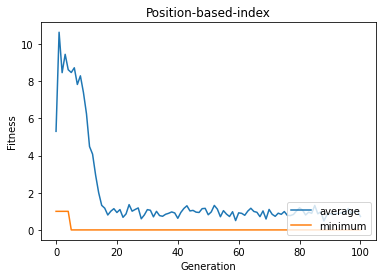

In [373]:
gen, avg, min_ = log.select("gen", "avg", "min")

plt.title("Position-based-index")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()



### 5 pts:  Print out the best individual found and its fitness value.  Show the best individual as chessboard

In [374]:
best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is:', best_ind)
print('Eval Fitness Value:',eval_fitness(best_ind))
show_grid(best_ind, board_size)


Best individual is: [4, 21, 10, 18, 7]
[]
Eval Fitness Value: (0,)
-|-|-|-|X|
----------
-|-|X|-|-|
----------
X|-|-|-|-|
----------
-|-|-|X|-|
----------
-|X|-|-|-|
----------


## Part II: Row-index-based board representation

In [375]:
import random
import numpy as np
from deap import algorithms, base, creator, tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


Each row of the chess row is indexed from 0->7 . we place different queens on different rows initially.  The sequence [ a b c d .... ] means that in $0^{th}$ row, $a^{th}$ column, the queen is present and so on

In [376]:
toolbox = base.Toolbox()

toolbox.register("attr_int", random.randint, 0, board_size-1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_int, n=board_size)

In [377]:
toolbox.individual()

[2, 4, 2, 4, 0]

In [378]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [379]:
pop = toolbox.population(n=1000)

print(pop[0])

[3, 3, 4, 0, 3]


In [380]:
def show_grid(board, board_size):
    dashes = "--------------------------------"
    dashes = dashes[:(board_size * 2)]
    n = [0] * (board_size * board_size)
    for i in range(len(board)):
        n[board[i] + i * board_size] = 1
    for i in range(board_size):
        for j in range(board_size * board_size):
            if j // board_size == i:
                if n[j] == 1:
                    print('X', end="|")
                else:
                    print('-', end="|")
        print()
        print(dashes)

In [381]:
show_grid(pop[0], board_size)

-|-|-|X|-|
----------
-|-|-|X|-|
----------
-|-|-|-|X|
----------
X|-|-|-|-|
----------
-|-|-|X|-|
----------


### 10 pts:  Write your code in the cell below to define the "evaFitness" function, which return the fitness of any given board

- evaFitness() returns the total number of distinct pairs of queens that attack each other.  

- The following are some test cases you may use to verify the correctness of the evaFitness() function:

 * evaFitness([0, 2, 6, 7, 7, 4, 1, 6]) should return (4,)

 * evaFitness([7, 5, 2, 4, 3, 1, 3, 5]) should return (6,)

 * evaFitness([3, 1, 6, 0, 5, 7, 2, 1]) should return (5,)

 * evaFitness([7, 3, 1, 4, 5, 1, 3, 5]) should return (6,)



## compute_conflicts()
Computes the number of conflicts in a given board using a frequency list representation of the board in linear time row a row-index representation. Based on following method described in the following page: https://towardsdatascience.com/computing-number-of-conflicting-pairs-in-a-n-queen-board-in-linear-time-and-space-complexity-e9554c0e0645

In [382]:
def compute_conflicts(board):
    n = len(board)
    row = [0] * n
    diag_right = [0] * (2 * n)
    diag_left = [0] * (2 * n)
    
    for i in range(n):
        print(i)
        row[board[i]] += 1
        diag_right[board[i] + i] += 1
        diag_left[n - board[i] + i] += 1
    
    conflicts = 0
    for i in range(2 * n):
        if i < n:
            conflicts += (row[i] * (row[i] - 1)) / 2
        conflicts += (diag_right[i] * (diag_right[i] - 1)) / 2
        conflicts += (diag_left[i] * (diag_left[i] - 1)) / 2
    return int(conflicts) 

In [383]:
#list1 = [0, 2, 6, 7, 7, 4, 1, 6]
#list2 = [7, 5, 2, 4, 3, 1, 3, 5]
#list3 = [3, 1, 6, 0, 5, 7, 2, 1]
#list4 = [7, 3, 1, 4, 5, 1, 3, 5]

In [384]:
#fitness function
def eval_fitness(individual):
    conflict = compute_conflicts(individual)
    return (conflict, )

In [385]:
#print(eval_fitness(list1))
#print(eval_fitness(list2))
#print(eval_fitness(list3))
#print(eval_fitness(list4))

### 5 pts:  Writer your code in the cell below to register "evaluate" function to toolbox

In [386]:

toolbox.register("evaluate", eval_fitness)


In [387]:

toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutUniformInt, low = 0, up = 7, indpb=0.1)

toolbox.register("select", tools.selTournament, tournsize=3)



In [388]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)


stats.register("avg", np.mean)
stats.register("min", np.min)



### 10 pts:  Writer your code in the cell below to create the first generation, the hall of fame, and launch the genetic algorithm: eaSimple().   How many individuals you want to have for each generation and how many generations you want GA to go thourgh for each run?     Vary those two parameters to see the change. 

In [389]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

stats = tools.Statistics(key=lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("min", np.min)

pop = toolbox.population(n=1000)

hof = tools.HallOfFame(maxsize=10)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, 
                                   stats=stats, halloffame=hof, verbose=True)


0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1


IndexError: list index out of range

### 5 pts:  Plot the "avg" and "min" for each generation

In [ ]:
# Plot the "avg" and "min" for each generation

gen, avg, min_ = log.select("gen", "avg", "min")

plt.title("Row-based-index")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

### 5 pts:  Print out the best individual found and its fitness value.  Show the best individual as chessboard

In [ ]:
best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is:', best_ind)
print('Number of conflicts:',compute_conflicts(best_ind))
show_grid(best_ind, board_size)


### Reflection:  Which board representaion is better in terms of ease of coding and final solution quality?   Try different parameter values for mutation and crossover and vary the number of generations and the population size.  Write your findings in the report.        

We believe that row-index representation exceeds position-index representation because we are able to put a constraint on one of the fundamental ways queens may attack each other, reducing our search space by a substantial amount. However, programming an evaluation function for this representation required viewing each queen's conflict as a complete graph, which is a much more complex algorithm than the one written for positional-indexing. In other words, row-index representation is more complex to program, but it also yields higher quality results. 
    
Solution quality:
    Row-index representation